# Optimization methods & acceleration

In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import imp

In [11]:
import numpy as np
from scipy.special import psi
from statsmodels.sandbox.regression.gmm import GMM

In [12]:
import sys
sys.path.append('simulate.py')
import simulate as sim

In [13]:
imp.reload(sim)

<module 'simulate' from '/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/examples/simulation/method_of_moments/simulate.py'>

In [14]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2

In [15]:
X, z = sim.simulate_true_counts(
    N=5000,
    mean_coef = np.array([1, 0.1]),
    var_coef = np.array([2, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq) 

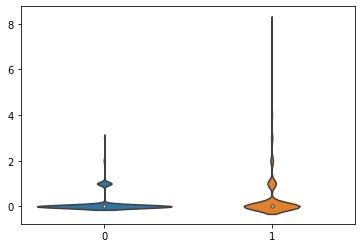

In [16]:
sns.violinplot(pd.Series(X[:, 0]), y.ravel())

### Naive implementation

In [35]:
class MeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(MeanGMM, self).__init__(*args, **kwds)
        
    
    def fitstart(self):
        
        y = self.endog.reshape(-1, 1)/self.q
        x_mat = self.exog
        ylog = np.log(y+1)
        sol, _, _, _ = np.linalg.lstsq(x_mat, ylog, rcond=-1)
        
        return sol.reshape(-1)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        return a
    
class VarianceGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(VarianceGMM, self).__init__(*args, **kwds)
        
        
    def fitstart(self):
        
        y = self.endog.reshape(-1, 1)/self.q
        ylog = np.log(y+1)
        x_mat = self.exog
        mean_beta = self.mean_beta.reshape(-1, 1)
        
        res = (ylog-x_mat@mean_beta)**2
        sol, _, _, _ = np.linalg.lstsq(x_mat, res, rcond=-1)
        return sol.reshape(-1)

    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog
        mean_beta = self.mean_beta.reshape(-1, 1)

        var_beta = params.reshape(-1, 1)
        
        a = (x_mat*y**2)/self.q_sq
        b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
        c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
        d = np.exp(2*x_mat@mean_beta)*x_mat
        e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
        return a + b + c + d + e

class CombinedGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 4)
        kwds.setdefault('k_params', 4)
        super(CombinedGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        mean_beta, var_beta = np.split(params.reshape(-1, 1), 2)
                
        mean_error =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@mean_beta))
        
        a = (x_mat*y**2)/self.q_sq
        b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
        c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
        d = np.exp(2*x_mat@mean_beta)*x_mat
        e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
        
        var_error = a + b + c + d + e
    
        return np.hstack([mean_error, var_error])

In [36]:
X, z = sim.simulate_true_counts(
    N=10000,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

init = np.ones(2)*(np.log(y+1).mean()/2)

mean_model = MeanGMM(y, X, instrument=None, q=p, q_sq=p_sq)
mean_model.nobs = y.shape[0]
mean_res = mean_model.fit(None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))
mean_beta = mean_res.params

var_model = VarianceGMM(y, X, instrument=None, q=p, q_sq=p_sq, mean_beta=mean_beta, gamma=1)
var_res = var_model.fit(None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))

combined_model = CombinedGMM(y, X, instrument=None, q=p, q_sq=p_sq, gamma=1)
combined_res = combined_model.fit(np.concatenate([init, init]), maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))


print(mean_res.summary())
print(var_res.summary())
# print(combined_res.summary())

                               MeanGMM Results                                
Dep. Variable:                      y   Hansen J:                    2.721e-08
Model:                        MeanGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Fri, 25 Oct 2019                                         
Time:                        19:59:08                                         
No. Observations:               10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0102      0.054     18.624      0.000       0.904       1.117
const          0.0754      0.044      1.718      0.086      -0.011       0.162
                             VarianceGMM Results                              
Dep. Variable:                      y   Hansen J:   

### Proportion based GMMs

In [437]:
class FastMeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(FastMeanGMM, self).__init__(*args, **kwds)
        
    
    def fitstart(self):
        
        y_val, y_counts = self.endog[:, 0].reshape(-1, 1), self.endog[:, 1].reshape(-1, 1)
        x_mat = self.exog
        
        ylog = np.log(y_val+1)
        sol, _, _, _ = np.linalg.lstsq(x_mat*y_counts, ylog*y_counts, rcond=-1)
        
        return sol.reshape(-1)


    def momcond(self, params):
                
        y_val, y_counts = self.endog[:, 0].reshape(-1, 1), self.endog[:, 1].reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y_val)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        
        #print(a.shape, y_counts.shape)
        return a * y_counts


In [438]:
X, z = sim.simulate_true_counts(
    N=100000,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

In [444]:
%%time
mean_model = FastMeanGMM(
    df[['y', 'count']].values, 
    df[['treatment', 'intercept']].values,
    instrument=None, q=p, q_sq=p_sq)
mean_res = mean_model.fit(np.array([1 , 0.1]), maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))
#print(mean_res.summary())




CPU times: user 17.7 ms, sys: 42 µs, total: 17.7 ms
Wall time: 15.7 ms


In [445]:
mean_res.params

array([0.99096836, 0.10506118])

In [442]:
mean_res.params

array([0.9908973 , 0.10513125])

### Numerical optimization for mean

In [296]:
X, z = sim.simulate_true_counts(
    N=10000,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]
df['count_2'] = df['count'] + np.random.randint(0, 10, size=df.shape[0])

In [272]:
def fit_start():
    
    y_val, y_counts = df['y'].values.reshape(-1, 1), df['count'].values.reshape(-1, 1)
    x_mat = df[['treatment', 'intercept']].values

    ylog = np.log(y_val+1)
    sol, _, _, _ = np.linalg.lstsq(x_mat*y_counts, ylog*y_counts, rcond=-1)

    return sol.reshape(-1)

In [369]:
y_val, y_counts_1, y_counts_2 = \
    df['y'].values.reshape(-1, 1), \
    df['count'].values.reshape(-1, 1), \
    df['count_2'].values.reshape(-1, 1)
    
x_mat = df[['treatment', 'intercept']].values

In [370]:
y_counts = df[['count', 'count_2', 'count_2']].values.reshape(-1, 1, 3)

In [371]:
y_counts.shape

(14, 1, 3)

In [372]:
y_counts.reshape(-1, 1, 3).shape

(14, 1, 3)

In [373]:
x_mat.shape

(14, 2)

In [376]:
y_counts.shape

(14, 1, 3)

In [374]:
res = x_mat.reshape(14, 2, -1)*y_counts

In [375]:
res.mean(axis=0)

array([[359.5       , 362.07142857, 362.07142857],
       [714.28571429, 718.35714286, 718.35714286]])

In [327]:
res.shape

(14, 2, 3)

In [332]:
res[:, :, 2]

array([[   0, 4456],
       [   0,  482],
       [   0,   44],
       [   0,    5],
       [   0,    1],
       [3952, 3952],
       [ 786,  786],
       [ 218,  218],
       [  63,   63],
       [  25,   25],
       [   9,    9],
       [   9,    9],
       [   3,    3],
       [   4,    4]])

In [333]:
x_mat * y_counts_2

array([[   0, 4456],
       [   0,  482],
       [   0,   44],
       [   0,    5],
       [   0,    1],
       [3952, 3952],
       [ 786,  786],
       [ 218,  218],
       [  63,   63],
       [  25,   25],
       [   9,    9],
       [   9,    9],
       [   3,    3],
       [   4,    4]])

In [312]:
y_counts

array([[4447, 4456],
       [ 481,  482],
       [  35,   44],
       [   3,    5],
       [   1,    1],
       [3949, 3952],
       [ 782,  786],
       [ 218,  218],
       [  56,   63],
       [  17,   25],
       [   4,    9],
       [   5,    9],
       [   1,    3],
       [   1,    4]])

### Figure out dimensions and broadcasting

In [408]:
y_val, y_counts = df['y'].values.reshape(-1, 1), df[['count', 'count_2']].values.reshape(-1, 1, 2)
x_mat = df[['treatment', 'intercept']].values

beta_hat = np.vstack([np.array([1.0, 0.1]), np.array([1.1, 0.1])]).T

In [409]:
part_1 = ((x_mat*y_val)/p)
part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, beta_hat.shape[1])

momcond = (part_1 - part_2*part_3)
weighted_momcond = momcond * y_counts

In [410]:
weighted_momcond.mean(axis=0)

array([[  5.00231439, -14.26233438],
       [ 16.47488939,  13.40962709]])

In [340]:
def mean_objective_perm(params):

    y_val, y_counts = df['y'].values.reshape(-1, 1), df[['count', 'count_2']].values.reshape(-1, 1, 2)
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, 1)

    a =  ((x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat)))
    a = a.reshape(a.shape[0], a.shape[1], -1)

    momcond = (a * y_counts).mean(axis=0)
    
    return (momcond**2).sum()

In [509]:
def mean_objective(params):

    y_val, y_counts = df['y'].values.reshape(-1, 1), df['proportion'].values.reshape(-1, 1)
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, 1)

    a =  (x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat))

    momcond = (a * y_counts).mean(axis=0)
    
    return (momcond**2).sum()

In [274]:
start = fit_start()

In [293]:
%%time
sp.optimize.minimize(
    mean_objective, 
    np.array([1.0, 0.1]),
    method='Nelder-Mead', 
    options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000033
         Iterations: 39
         Function evaluations: 74
CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 108 ms


 final_simplex: (array([[1.02132555, 0.07663115],
       [1.02132684, 0.07662921],
       [1.02132248, 0.07663292]]), array([3.30314006e-05, 7.17309876e-05, 9.95056087e-05]))
           fun: 3.303140063249221e-05
       message: 'Optimization terminated successfully.'
          nfev: 74
           nit: 39
        status: 0
       success: True
             x: array([1.02132555, 0.07663115])

### Generate multivariate permutations

In [499]:
N = 10000
num_perm = 10
X, z = sim.simulate_true_counts(
    N=N,
    mean_coef = np.array([1.0, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)

y = sim.simulate_dropout(z, p, p_sq)

df = pd.DataFrame(
    data=np.hstack([X, y]),
    columns=['treatment', 'intercept', 'y'])
df = df.groupby(df.columns.tolist()).size().reset_index(name='count')
df['proportion'] = df['count'] / X.shape[0]

for perm_idx in range(1, num_perm+1):
    
    df['pc_{}'.format(perm_idx)] = stats.multinomial.rvs(N, df['proportion'])

In [510]:
def mean_objective_perm(params):

    y_val, y_counts = df['y'].values.reshape(-1, 1), df.iloc[:, -num_perm:].values.reshape(-1, 1, num_perm)/N
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, num_perm, order='F')

    part_1 = ((x_mat*y_val)/p)
    part_1 = part_1.reshape(part_1.shape[0], part_1.shape[1], -1)

    part_2 = x_mat.reshape(x_mat.shape[0], x_mat.shape[1], -1)

    part_3 = np.exp(x_mat@beta_hat).reshape(-1, 1, beta_hat.shape[1])

    momcond = (part_1 - part_2*part_3)
    weighted_momcond = momcond * y_counts
    
    return (weighted_momcond**2).sum()

def mean_objective(params):

    y_val, y_counts = df['y'].values.reshape(-1, 1), df['proportion'].values.reshape(-1, 1)
    x_mat = df[['treatment', 'intercept']].values

    beta_hat = params.reshape(-1, 1)

    a =  (x_mat*y_val)/p - (x_mat*np.exp(x_mat@beta_hat))

    momcond = (a * y_counts).mean(axis=0)
    
    return (momcond**2).sum()

In [513]:
start = np.concatenate(
    [np.array([1.0, 0.1]) for i in range(num_perm)])

In [514]:
%%time
mean_objective_perm(start)

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 2.63 ms


40.567456958948014

In [515]:
%%time
mean_objective(np.array([1.0, 0.1]))

CPU times: user 2.15 ms, sys: 0 ns, total: 2.15 ms
Wall time: 2 ms


0.00020726179544519716

In [504]:
%%time
res = sp.optimize.minimize(
    mean_objective_perm, 
    start,
    method='bfgs', 
    options={'disp': True})

Optimization terminated successfully.
         Current function value: 15.909858
         Iterations: 70
         Function evaluations: 1584
         Gradient evaluations: 72
CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.45 s


In [ ]:
1.38*

### Gradient of the mean objective

In [308]:
X, z = sim.simulate_true_counts(
    N=1000000,
    mean_coef = np.array([0.1, 0.1]),
    var_coef = np.array([1.6, 0.1]),
    num_levels=2,
    p=1)
y = z
W = np.eye(2)


In [315]:
def objective(beta):
    param = beta.reshape(-1, 1)
    
    G = (X*(z-np.exp(X@param))).mean(axis=0)#.reshape(-1, 1)
    
    return G.T@W@G

def objective_grad(beta):
    
    return -(2*X*np.exp(X@beta.reshape(-1, 1))).T@X@W@X.T@(z-np.exp(X@beta.reshape(-1, 1)))/5000**2

In [309]:
G.shape

(2,)

In [310]:
W = np.eye(2)

In [311]:
W

array([[1., 0.],
       [0., 1.]])

In [312]:
beta_true =  np.array([0.10, 0.1])#.reshape(-1, 1)

In [313]:
%%time
num_grad = opt.approx_fprime(beta_true,objective , np.sqrt(np.finfo(float).eps))


CPU times: user 89.1 ms, sys: 1.03 ms, total: 90.1 ms
Wall time: 88 ms


In [314]:
%%time
ana_grad = objective_grad(beta_true).reshape(-1)


CPU times: user 72.3 ms, sys: 944 µs, total: 73.3 ms
Wall time: 71.3 ms


In [304]:
num_grad = opt.approx_fprime(beta_true,objective , np.sqrt(np.finfo(float).eps))
ana_grad = objective_grad(beta_true).reshape(-1)
print(num_grad, ana_grad)
print(np.mean((num_grad-ana_grad)**2))

[0.05711382 0.08252242] [0.0571138  0.08252239]
3.9533851097632414e-16


In [286]:
objective_grad(beta_true)

array([[0.2316969 ],
       [0.32807452]])

In [293]:
%%time
a = opt.check_grad(objective, objective_grad, x0=beta_true)

CPU times: user 2.14 ms, sys: 2 ms, total: 4.15 ms
Wall time: 3.49 ms


In [294]:
a

array([0.09637761, 0.09637765])

In [280]:
def objective(beta):
    param = beta.reshape(-1, 1)
    
    G = (X*(z-np.exp(X@param))).mean(axis=0)#.reshape(-1, 1)
    
    return G.T@W@G

def objective_grad(beta):
    
    return -(2*X*np.exp(X@beta.reshape(-1, 1))).T@X@W@X.T@(z-np.exp(X@beta.reshape(-1, 1)))/5000**2

In [258]:
%%time
opt.check_grad(objective, objective_grad, beta_true)

CPU times: user 1.63 ms, sys: 1.02 ms, total: 2.66 ms
Wall time: 1.92 ms


array([0.02540858, 0.02540861])

In [250]:
integral_check = np.zeros((50,50))
first = np.linspace(0,3,50)
second = np.linspace(0,3,50)
for i1, f in enumerate(first):
    for i2, s in enumerate(second):
        integral_check[i1,i2] = np.sum((objective_grad(np.array([f,s]))-opt.approx_fprime(np.array([f,s]), objective, epsilon=1e-2))**2)
        

In [251]:
integral_check[-1, -1]

47185439.320186734

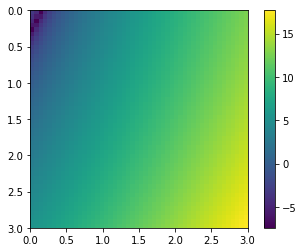

In [254]:
plt.imshow(np.log(integral_check),extent=[0,3,3,0])
#plt.axis('square')
plt.colorbar()

In [165]:
# class MeanGMM(GMM):

    
#     def __init__(self, *args, **kwds):
#         # set appropriate counts for moment conditions and parameters
#         # TODO: clean up signature
#         kwds.setdefault('k_moms', 2)
#         kwds.setdefault('k_params', 2)
#         super(MeanGMM, self).__init__(*args, **kwds)


#     def momcond(self, params):
                
#         y = self.endog[:, 0].reshape(-1, 1)
#         counts = self.endog[:, 1].reshape(-1, 1)
        
#         x_mat = self.exog

#         beta_hat = params.reshape(-1, 1)
        
#         a =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@beta_hat))
#         return a * counts
    
# class VarianceGMM(GMM):

    
#     def __init__(self, *args, **kwds):
#         # set appropriate counts for moment conditions and parameters
#         # TODO: clean up signature
#         kwds.setdefault('k_moms', 2)
#         kwds.setdefault('k_params', 2)
#         super(VarianceGMM, self).__init__(*args, **kwds)


#     def momcond(self, params):
                
#         y = self.endog[:, 0].reshape(-1, 1)
#         counts = self.endog[:, 1].reshape(-1, 1)
        
#         x_mat = self.exog
        
#         mean_beta = self.mean_beta.reshape(-1, 1)
#         var_beta = params.reshape(-1, 1)
        
#         a = (x_mat*y**2)/self.q_sq
#         b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
#         c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
#         d = np.exp(2*x_mat@mean_beta)*x_mat
#         e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
#         return counts*(a + b + c + d + e)

In [177]:
(2*X*np.exp(X@beta_true.reshape(-1, 1))).mean(axis=0)

array([3.01462052, 4.11594544])

In [191]:
-(2*X*np.exp(X@beta_true.reshape(-1, 1))).T@X@W@X.T@(z-np.exp(X@beta_true.reshape(-1, 1)))/100000**2

array([[0.01481078],
       [0.01721467]])

In [41]:
objective(beta_true)

(2,)


0.00014312910540704592